In [1]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import os

import numpy as np
from sklearn.utils import resample
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import hdbscan
import umap
import time

import optuna

2025-07-03 09:07:02.755861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 09:07:02.759540: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 09:07:02.769771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751526422.786572  128863 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751526422.791528  128863 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751526422.805108  128863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Application of unsupervised learning : Spotify Tracks DB

## The dataset
The chosen [dataset](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db/data?select=SpotifyFeatures.csv) is collection of 232,725 tracks across 26 genres of music retrieved from Spotify along with measures that the Spotify API provides. The measures include the following: 
- acousticness: a confidence metric between 0 and 1 on whether the track is acoustic
- danceability: a confidence metric between 0 and 1 on whether the track is danceable or not; this based on: tempo, rhythm stability, beat strength, and overall regularity.
- energy: a measure of energy between 0 and 1 based on: dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- instrumentalness: the likelyhood of a track not containing vocal content (aside from vocalisation).
- liveness: the probability of a track being performed live based on the perceived presence of an audience. 0.8 is considered high enough to label a track as a live performance.
- loudness: overall loudness in decibels (dB), averaged over the track. Frequently in the range of -60 and 0 db.
- speechiness: a metric between 0 and 1 to represent the presence of speech in a track (speech as in a podcast). Below 0.33 is considered music, between 0.33 and 0.66 is considered a mix of music and speech, and above 0.66 is considered pure speech.
- valence: a metric describing the positiveness of a track; positive being happiness and negative being sadness and anger.

For more information about the Spotify API measure, please refer to the [documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-features).

In [2]:
path = kagglehub.dataset_download("zaheenhamidani/ultimate-spotify-tracks-db")
df = pd.read_csv(os.path.join(path, "SpotifyFeatures.csv"))
df

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489


## Data analysis

In [3]:
df['genre'] = df['genre'].replace({
    "Children’s Music": "Children's Music",
})

Tracks are evenly distributed across genres with the exception of acapella music being barely present in the dataset as well as children's music which is the combination of "children's music" and "children's music" (seperately they fit the uniform distribution). The dataset would be suitable to be exploited for tasks requiring good genre representation.

/tmp/ipykernel_128863/900864372.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_genres, x='genre', y='count', palette='viridis')


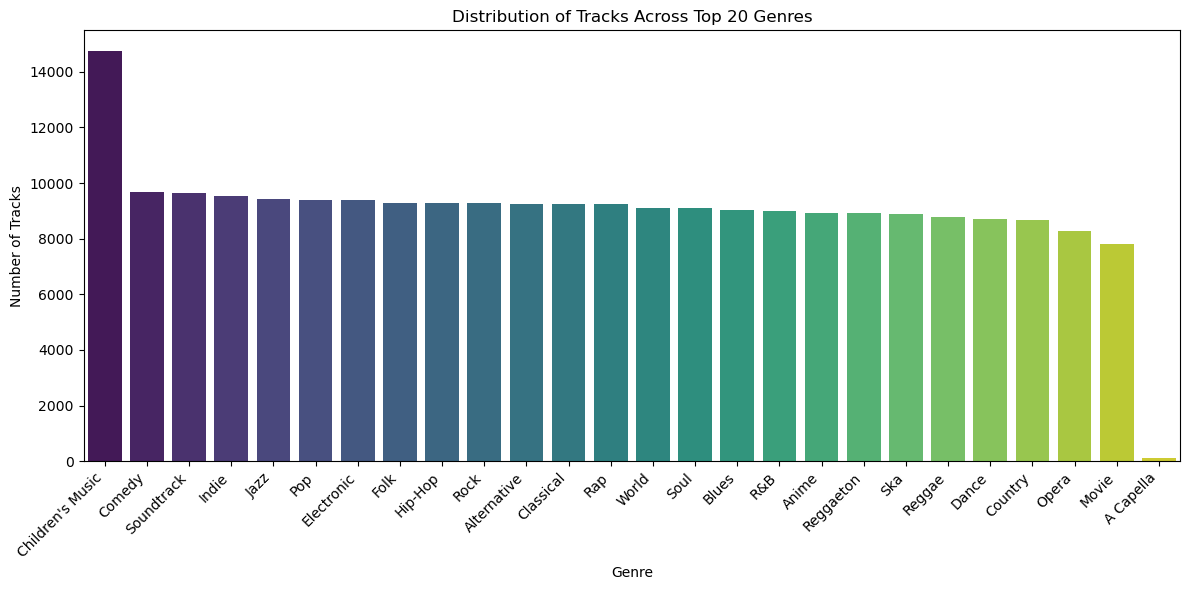

In [4]:
top_genres = df['genre'].value_counts().reset_index()
top_genres.columns = ['genre', 'count']
plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres, x='genre', y='count', palette='viridis')
plt.title('Distribution of Tracks Across Top 20 Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Valence is slightly skewed in favor of negative tracks with an outlier of strongly negative tracks. Cutting below 0.7 valence yields a fairly even distribution. 

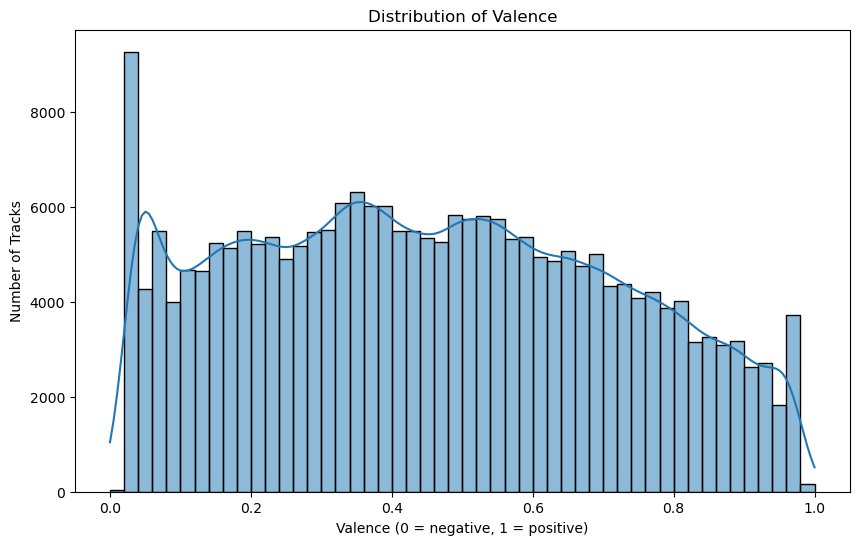

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['valence'], kde=True, bins=50)
plt.title('Distribution of Valence')
plt.xlabel('Valence (0 = negative, 1 = positive)')
plt.ylabel('Number of Tracks')
plt.show()

We note a long tail as exprected in a dataset where data has been randomly collected as should be done. We also note an outlier representing undiscovered tracks. This dataset can also be exploited for popularity prediction and thus recommendation tasks.

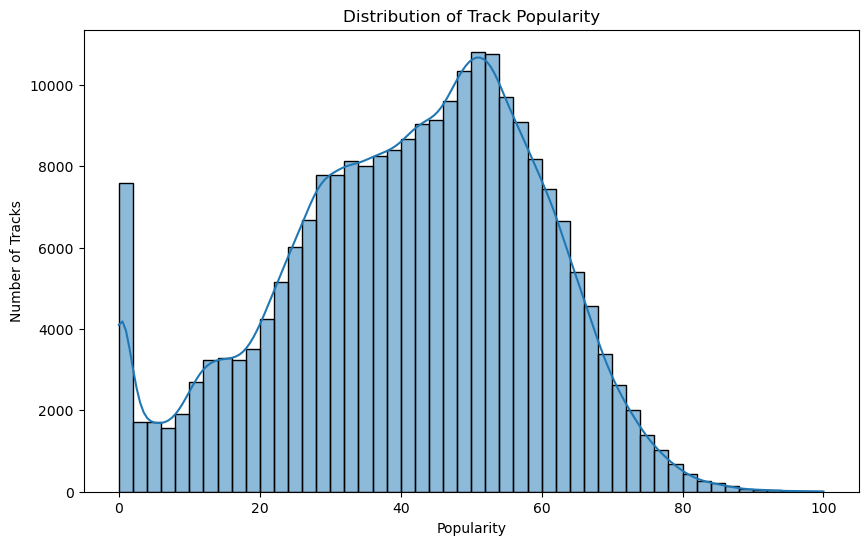

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=50, kde=True)
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Tracks')
plt.show()

There's a somewhat trivial strong correlation between metrics that are based on shared characteristics of a track such as acousticness and loudness, energy and loudness. On the middle end of correaltion values we find more interesting correlations such as danceability/loudness, danceability/valence, and valence/loudness. However, these are still predictable in the way that they make sense in the real world. It would be interesting to explore the lower (but still high enough to be relevant) values such as instrumentalness/valence. This could shed some light on the tendencies of musical genres as well.

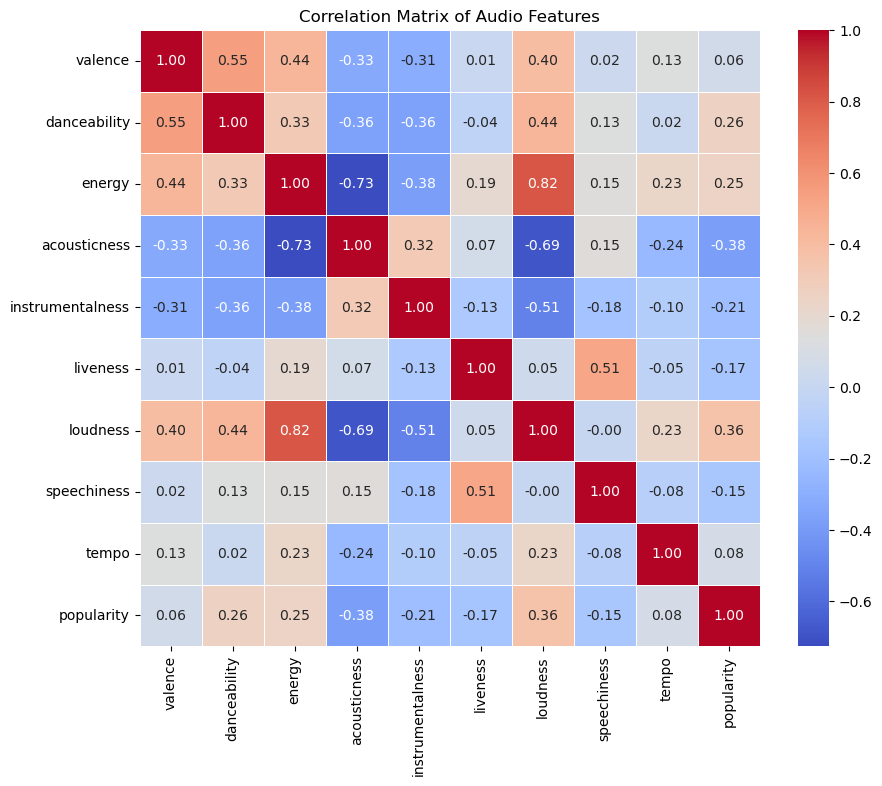

In [7]:
features = ['valence', 'danceability', 'energy', 'acousticness',
            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'popularity']

corr_matrix = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Audio Features')
plt.show()

## The task

The task is to perform unsupervised clustering of music tracks based on their Spotify API audio features.
- **The problem:** Due to the ease of exposure of different cultures and subcultures to each other today, music rarely follows a genre in its classical sense and people rarely tie their identity with one genre. Genres get mixed and people can access and enjoy different types of music. Recommending a track is not as simple as referring to the group a person identifies with, it is tied to more subtle properties that people develop a preference for without even knowing. 
- **The choice of the dataset:** As seen in the data visualization, the Spotify dataset is rich in both variety and information about the tracks.
- **The goal:** To uncover the hidden structure in how music is distributed across new genres that we will find through natural grouping.
- **Use in the industry:** Unsupervised clustering on content is generally done to improve and assist recommender systems by enhancing diversity without straying too far from the user's preferences. It is particularly effective against the long tail problem. We also continue to see new ways our streaming platforms recommend music to us, such as generated playlists. These can also benefit from the diversity offered by unsupervised clustering.

## Preprocessing

We remove tracks with the genre A Capella as there isn't enough data on them. These are typically sought after rather than found so generally, they should not be recommended.

In [8]:
df = df[df['genre'] != 'A Capella']

As we grouped the genres "children's music" and "children`s" music which debalanced the distribution, we cut down first by checking for duplicates then we sample the right amount of tracks.

In [9]:
df = df.drop_duplicates()

In [10]:
reference_genre = 'Jazz'
target_size = df[df['genre'] == reference_genre].shape[0]
child_music_df = df[df['genre'] == "Children's Music"].sample(n=target_size, random_state=42)
non_child_music_df = df[df['genre'] != "Children's Music"]
df = pd.concat([non_child_music_df, child_music_df])

In [11]:
df = df.reset_index(drop=True)

/tmp/ipykernel_128863/900864372.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_genres, x='genre', y='count', palette='viridis')


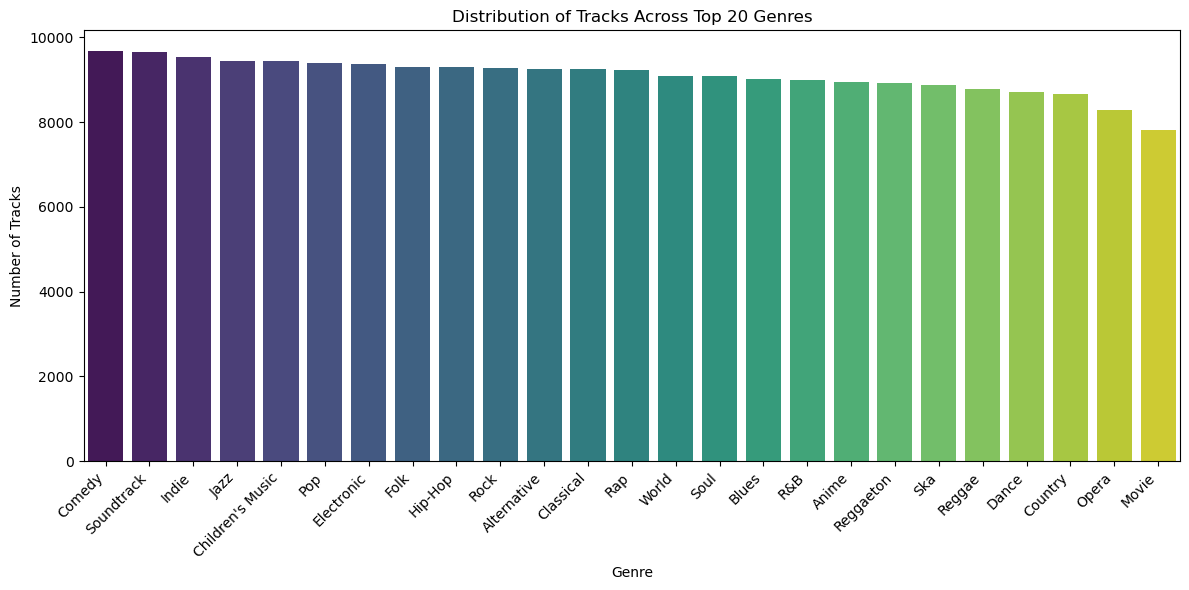

In [12]:
top_genres = df['genre'].value_counts().reset_index()
top_genres.columns = ['genre', 'count']
plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres, x='genre', y='count', palette='viridis')
plt.title('Distribution of Tracks Across Top 20 Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
clustering_features = ['valence', 'danceability', 'energy', 'acousticness',
                      'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']
X = df[clustering_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_sample = resample(X, n_samples=10000, random_state=42)
X_sample_scaled = scaler.fit_transform(X_sample)

## Baseline: pure K-means clustering

In [14]:
# Finding the optimal k for k means clustering through silouhette score
def find_optimal_k_silhouette(X, k_range=range(2, 21)):
    silhouette_scores = []
    k_values = list(k_range)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    plt.show()
    
    optimal_k = k_values[np.argmax(silhouette_scores)]
    print(f"Optimal k based on silhouette score: {optimal_k}")
    return optimal_k, silhouette_scores

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

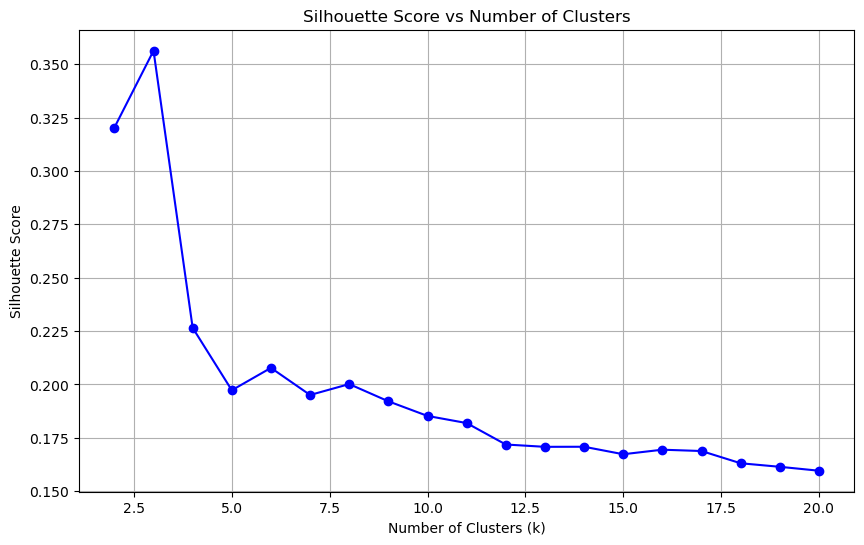

Optimal k based on silhouette score: 3
found optimal k: 3


In [15]:
optimal_k_sil, sil_scores = find_optimal_k_silhouette(X_sample_scaled)
print(f"found optimal k: {optimal_k_sil}")

In [16]:
# Finding the optimal k for k means clustering with the elbow method
def find_optimal_k_elbow(X, k_range=range(1, 21)):
    inertias = []
    k_values = list(k_range)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()
    
    differences = np.diff(inertias)
    second_differences = np.diff(differences)
    elbow_k = k_values[np.argmax(second_differences) + 2]
    print(f"Suggested k based on elbow method: {elbow_k}")
    return elbow_k, inertias

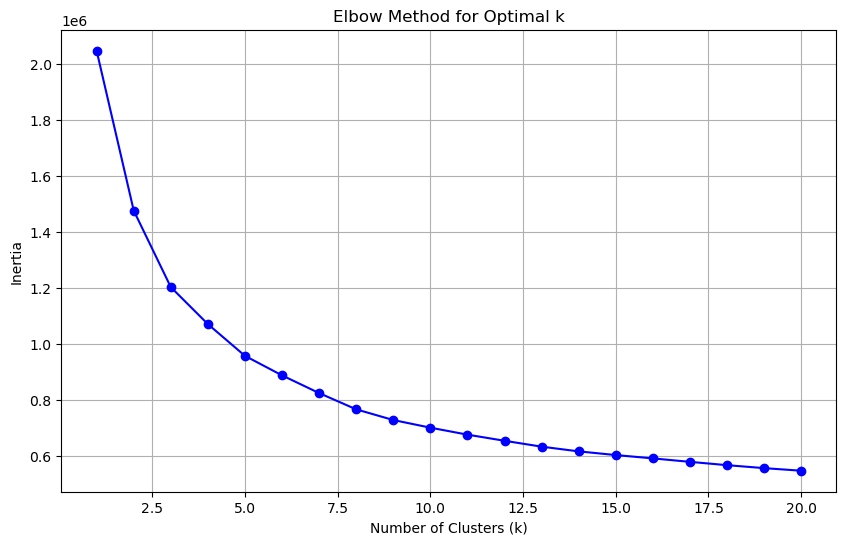

Suggested k based on elbow method: 3


In [17]:
optimal_k_elbow, inertias = find_optimal_k_elbow(X_scaled)

**Choosing the number of clusters:** The elbow method yields a *k* that minimizes the variance within a cluster, while the silhouette score takes into account the separation of clusters in addition to that. Luckily for us, both yield the same *k*, 3. It means that at this number of clusters, the data has a well-defined cluster structure with a high density within the clusters and good separation. Albeit low, and thus of little help to a recommender system, we will continue with this number of clusters.

In terms of method, we also note that using the elbow method is beneficial for large datasets, as we had to sample in order to compute the silhouette score, its complexity being quadratic. By applying the elbow method, we are more confident that 3 clusters is not only a good choice for the sample, but also the whole dataset. Similarly, we can also conclude (with less confidence) that our sampling is safe.

In [18]:
# Baseline K means 
optimal_k = optimal_k_sil
start_time = time.time()
kmeans_baseline = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_baseline.fit_predict(X_sample_scaled)
kmeans_time = time.time() - start_time

def evaluate_clustering(X, labels, method_name):
    if len(np.unique(labels)) < 2:
        print(f"{method_name}: Cannot compute metrics with < 2 clusters")
        return None, None, None
    
    try:
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        
        print(f"{method_name} Evaluation:")
        print(f"  Silhouette Score: {silhouette:.4f}")
        print(f"  Calinski-Harabasz Index: {calinski:.4f}")
        print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
        print(f"  Number of clusters: {len(np.unique(labels))}")
        print()
        
        return silhouette, calinski, davies_bouldin
    except Exception as e:
        print(f"Error evaluating {method_name}: {e}")
        return None, None, None

kmeans_sil, kmeans_ch, kmeans_db = evaluate_clustering(X_sample_scaled, kmeans_labels, "K-means (baseline)")
print(f"time = {kmeans_time}")

K-means (baseline) Evaluation:
  Silhouette Score: 0.3563
  Calinski-Harabasz Index: 3488.3432
  Davies-Bouldin Index: 1.0792
  Number of clusters: 3

time = 0.039733171463012695


## Dimensionality reduction

PCA reduced dimensions from 9 to 7
Explained variance ratio: 0.9564


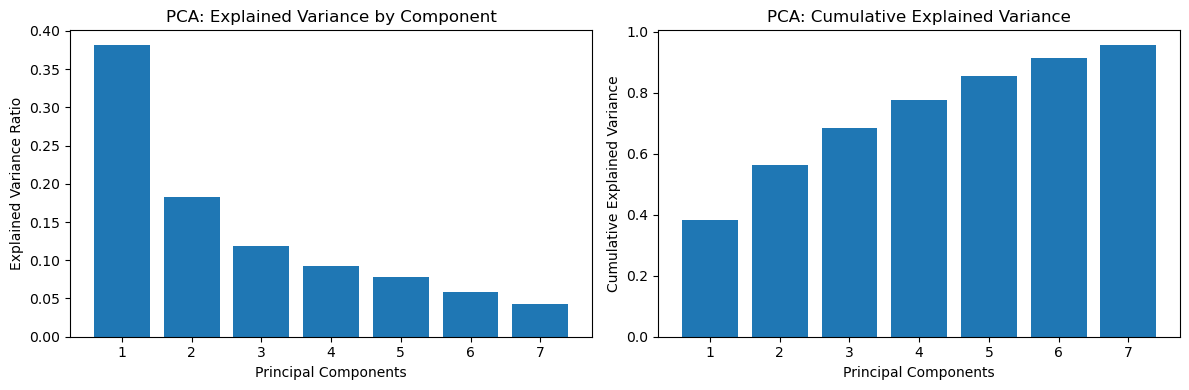

In [19]:
# PCA 
pca = PCA(n_components=0.95, random_state=42)  # Keep 95% of variance
X_pca = pca.fit_transform(X_sample_scaled)

print(f"PCA reduced dimensions from {X_scaled.shape[1]} to {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Explained Variance by Component')

plt.subplot(1, 2, 2)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')

plt.tight_layout()
plt.show()

Dimensionality reduction by PCA successfully helped cut down to 7 dimensions. According to the plots, most compoenents don't contribute substantially to the variance but eliminating one would mean eliminating the rest. Their cumulative variance shows that it is necessary to keep those components to hit the 0.95 mark of explained varaince.

/home/rania/Public/anaconda3/envs/recommender-env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


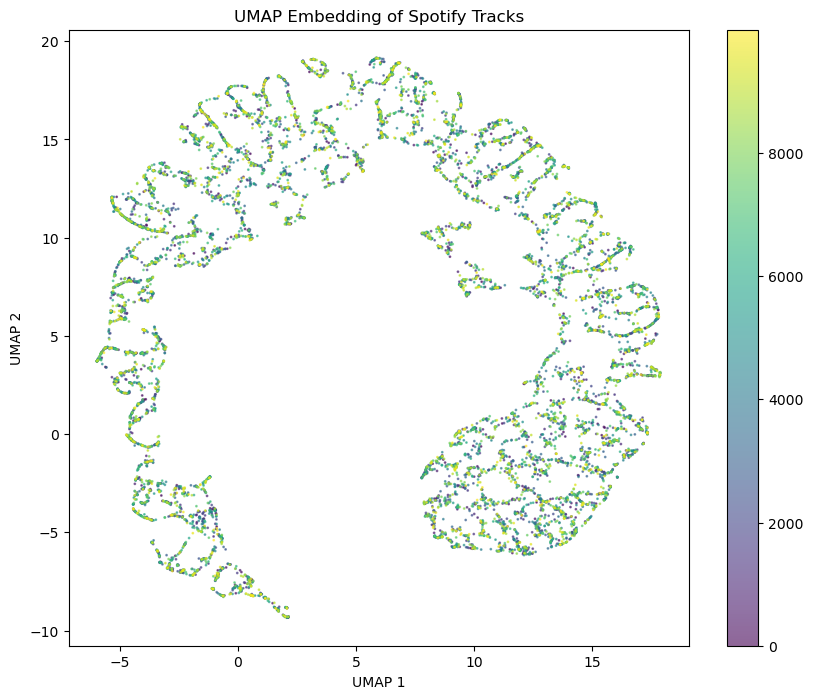

In [20]:
# UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap_reducer.fit_transform(X_sample)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=range(len(X_umap)), 
                     cmap='viridis', alpha=0.6, s=1)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Embedding of Spotify Tracks')
plt.colorbar(scatter)
plt.show()

We do a UMAP dimensionality reduction to get a good visualization of how the data behaves. While reading a UMAP projection, it is important to keep in mind that while the global positions of the clusters is well preserved, the distances between them is likely to be meaningless. We observed that by varying hyperparameters (the number of neighbours and minimal distance), the horseshoe like shape remains so it is likely tied to the structure of the data. Circularity in the unfolding of a manifold often indicates a continuous variation across characteristics of the clusters. The tendrils would be the niche subgenres with some diverging characteristics from that continuum.

## K-means clustering

In [21]:
# K means with dimensionality reduction
start_time = time.time()
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_pca_labels = kmeans_pca.fit_predict(X_pca)
kmeans_pca_time = time.time() - start_time

kmeans_pca_sil, kmeans_pca_ch, kmeans_pca_db = evaluate_clustering(X_sample_scaled, kmeans_pca_labels, "K-means with PCA")
print(f"time = {kmeans_pca_time}")

K-means with PCA Evaluation:
  Silhouette Score: 0.3564
  Calinski-Harabasz Index: 3488.1714
  Davies-Bouldin Index: 1.0790
  Number of clusters: 3

time = 0.05573153495788574


## DBSCAN clustering

We start by finding the optimal eps (neighbourhood radius) for our clustering. That would be a region where the minimal k-th nearest neighbour distance abrubtly increasing indicating a sepration, again what we call an "elbow". Still, we can't just take that value as we want a good balance of combining dense regions and not mistakenly merging clusters. As a heuristic, we assume that 5% of the points around a cluster are noise and use the 95th percentile of the distance instead.

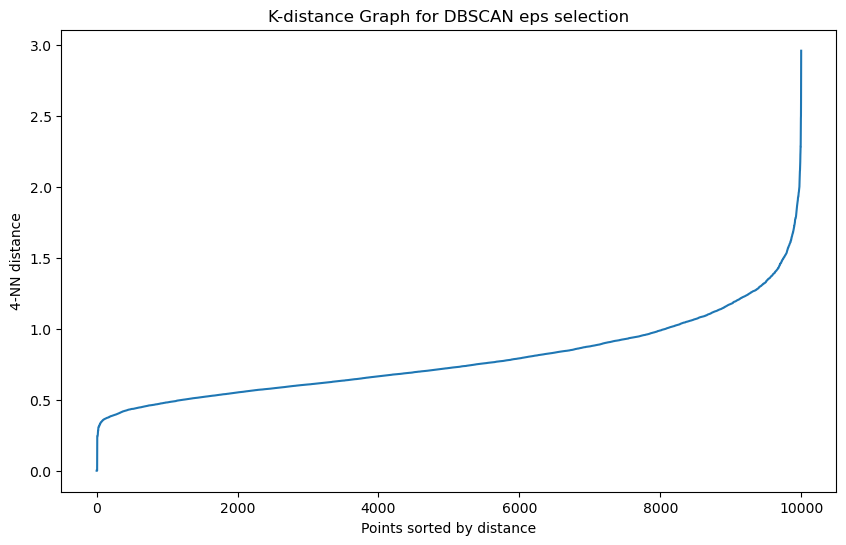

optimal eps = 1.3312665564251938


In [22]:
def find_optimal_eps(X, k=4):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-NN distance')
    plt.title('K-distance Graph for DBSCAN eps selection')
    plt.show()
    
    # Simple heuristic: use 95th percentile
    optimal_eps = np.percentile(distances, 95)
    return optimal_eps

eps_optimal = find_optimal_eps(X_sample_scaled)
print(f"optimal eps = {eps_optimal}")

min_sample is set to double of the number of features. It is closely tied to the number of features as more dimensions means more sparsity, which means we would need more core points to be able to legitimately claim the existence of a cluster. Multiplying that by to is just common practice that was found through experimentation to give a good sensitivity/offset balance most of the time.

In [23]:
# DBSCAN without dimentionality reduction
start_time = time.time()
dbscan_baseline = DBSCAN(eps=eps_optimal, min_samples=2 * X_sample_scaled.shape[1])
dbscan_labels = dbscan_baseline.fit_predict(X_sample_scaled)
dbscan_time = time.time() - start_time

print(f"DBSCAN found {len(np.unique(dbscan_labels))} clusters including {np.sum(dbscan_labels == -1)} noise points")

dbscan_sil, dbscan_ch, dbscan_db = evaluate_clustering(X_sample_scaled, dbscan_labels, "DBSCAN (no PCA)")
print(f"time = {dbscan_time}")

DBSCAN found 3 clusters including 661 noise points
DBSCAN (no PCA) Evaluation:
  Silhouette Score: 0.2414
  Calinski-Harabasz Index: 818.9338
  Davies-Bouldin Index: 2.4646
  Number of clusters: 3

time = 0.9965646266937256


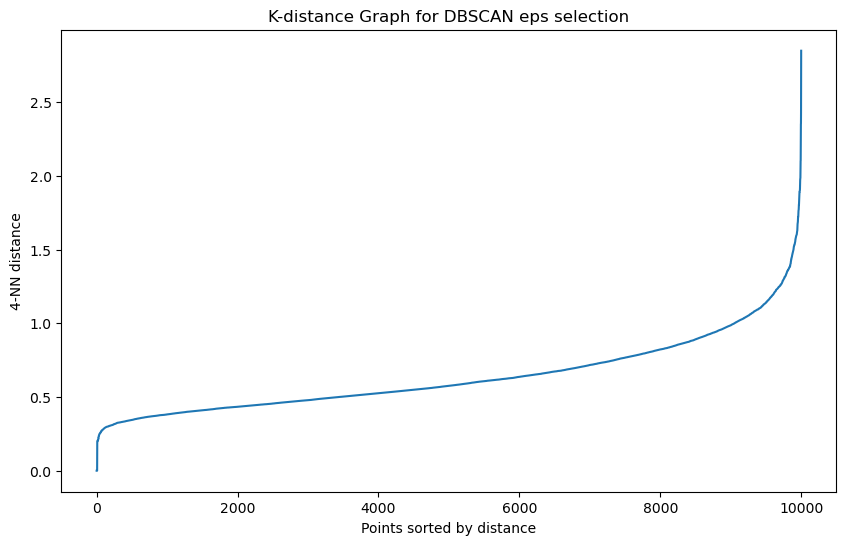

optimal eps = 1.1397317964894955


In [24]:
eps_pca = find_optimal_eps(X_pca)
print(f"optimal eps = {eps_pca}")

In [25]:
# DBSCAN with dimentionality reduction
start_time = time.time()
dbscan_pca = DBSCAN(eps=eps_pca, min_samples=2 * X_pca.shape[1])
dbscan_pca_labels = dbscan_pca.fit_predict(X_pca)
dbscan_pca_time = time.time() - start_time

print(f"DBSCAN found {len(np.unique(dbscan_pca_labels))} clusters including {np.sum(dbscan_pca_labels == -1)} noise points")

dbscan_pca_sil, dbscan_pca_ch, dbscan_pca_db = evaluate_clustering(X_sample_scaled, dbscan_pca_labels, "DBSCAN (with PCA)")
print(f"time = {dbscan_pca_time}")

DBSCAN found 4 clusters including 663 noise points
DBSCAN (with PCA) Evaluation:
  Silhouette Score: 0.1788
  Calinski-Harabasz Index: 566.7708
  Davies-Bouldin Index: 2.1762
  Number of clusters: 4

time = 0.49146604537963867


## HDBSCAN clustering

HDBSCAN works on the hypothesis of clusters of varying densities, so it could have an advantage over DBSCAN if that were the case with our data.

Previous trials with parameters that would correspond to the K-means and DBSCAN initial conditions returned just one cluster with HDBSCAN. HDBSCAN is much more sensitive to data that's not clearly separated. K-means inforces the number of clusters and DBSCAN results are mostly influenced by eps. In order to get meaningful results and stay close to the baseline for a fair comparison, we start with the same min_sample as DBSCAN and change the minimum cluster size accordingly.

In [26]:
print(f"min_cluster = {X_sample_scaled.shape[0]//optimal_k}")
print(f"min_samples = {2 * X_sample_scaled.shape[1]}")

min_cluster = 3333
min_samples = 18


In [27]:
# HDBSCAN without dimensionality reduction
start_time = time.time()
hdbscan_baseline = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=2 * X_sample_scaled.shape[1])
hdbscan_labels = hdbscan_baseline.fit_predict(X_sample_scaled)
hdbscan_time = time.time() - start_time

print(f"HDBSCAN found {len(np.unique(hdbscan_labels))} clusters including {np.sum(hdbscan_labels == -1)} noise points")

hdbscan_sil, hdbscan_ch, hdbscan_db = evaluate_clustering(X_sample_scaled, hdbscan_labels, "HDBSCAN (no PCA)")
print(f"time = {hdbscan_time}")

/home/rania/Public/anaconda3/envs/recommender-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rania/Public/anaconda3/envs/recommender-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN found 3 clusters including 243 noise points
HDBSCAN (no PCA) Evaluation:
  Silhouette Score: 0.2981
  Calinski-Harabasz Index: 797.7548
  Davies-Bouldin Index: 2.2731
  Number of clusters: 3

time = 0.9042098522186279


In [28]:
# HDBSCAN with dimensionality reduction
start_time = time.time()
hdbscan_pca = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=2 * X_sample_scaled.shape[1])
hdbscan_pca_labels = hdbscan_pca.fit_predict(X_pca)
hdbscan_pca_time = time.time() - start_time

print(f"DBSCAN found {len(np.unique(hdbscan_pca_labels))} clusters including {np.sum(hdbscan_pca_labels == -1)} noise points")

hdbscan_pca_sil, hdbscan_pca_ch, hdbscan_pca_db = evaluate_clustering(X_sample_scaled, hdbscan_pca_labels, "HDBSCAN (with PCA)")
print(f"time = {hdbscan_pca_time}")

/home/rania/Public/anaconda3/envs/recommender-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rania/Public/anaconda3/envs/recommender-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


DBSCAN found 3 clusters including 329 noise points
HDBSCAN (with PCA) Evaluation:
  Silhouette Score: 0.2772
  Calinski-Harabasz Index: 804.9625
  Davies-Bouldin Index: 2.3032
  Number of clusters: 3

time = 0.5753161907196045


## Experimental method: Gaussian Mixture Model

In [29]:
# GMM without dimensionality reduction
start_time = time.time()
gmm_baseline = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm_baseline.fit_predict(X_sample_scaled)
gmm_time = time.time() - start_time

gmm_sil, gmm_ch, gmm_db = evaluate_clustering(X_sample_scaled, gmm_labels, "GMM (no PCA)")
print(f"time = {gmm_time}")

GMM (no PCA) Evaluation:
  Silhouette Score: 0.0742
  Calinski-Harabasz Index: 892.2235
  Davies-Bouldin Index: 3.8259
  Number of clusters: 3

time = 0.0999600887298584


In [30]:
# GMM with dimensionality reduction
start_time = time.time()
gmm_pca = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_pca_labels = gmm_pca.fit_predict(X_pca)
gmm_pca_time = time.time() - start_time

gmm_pca_sil, gmm_pca_ch, gmm_pca_db = evaluate_clustering(X_sample_scaled, gmm_pca_labels, "GMM (with PCA)")
print(f"time = {gmm_pca_time}")

GMM (with PCA) Evaluation:
  Silhouette Score: 0.1255
  Calinski-Harabasz Index: 1598.1910
  Davies-Bouldin Index: 2.2110
  Number of clusters: 3

time = 0.11839962005615234


## Metric comparison

We chose to monitor the following metrics: 
- **Silhouette score:** is the difference between the average distance to points in the same cluster (cohesion) and the average distance to points in the nearest neighboring cluster (separation). Negative values indicate that the point is on average closer to the neighboring cluster than to its own cluster and thus poorly classified. Positive values indicate that the point is closer to its own cluster than to others, meaning it is well classified. 0.35 is a good value.
- **Calinski-Harabasz index:** also known as the Variance Ratio Criterion (VRC), it's the ratio between the variance between groups and the variance within groups. K-means maximizes this score by design.
- **Davies-Bouldin index:** the average of the maximum ratio between the distance of a point to the center of its group and the distance between two group centers.

By using all three metrics, we can have a more confidence in our comparisons as we respectively measure:
- point level wise with the Silouhette score
- global variance wise with the Calinski-Harabasz index
- cluster similarity and separation with the Davies-Bouldin index

In [31]:
results = {
    'Method': ['K-means', 'K-means + PCA', 
               'DBSCAN', 'DBSCAN + PCA',
               'HDBSCAN', 'HDBSCAN + PCA',
               'GMM', 'GMM + PCA'],
    'Time (s)': [kmeans_time, kmeans_pca_time,
                 dbscan_time, dbscan_pca_time,
                 hdbscan_time, hdbscan_pca_time,
                 gmm_time, gmm_pca_time],
    'Silhouette Score': [kmeans_sil, kmeans_pca_sil,
                        dbscan_sil, dbscan_pca_sil,
                        hdbscan_sil, hdbscan_pca_sil,
                        gmm_sil, gmm_pca_sil],
    'Calinski-Harabasz': [kmeans_ch, kmeans_pca_ch,
                         dbscan_ch, dbscan_pca_ch,
                         hdbscan_ch, hdbscan_pca_ch,
                         gmm_ch, gmm_pca_ch],
    'Davies-Bouldin': [kmeans_db, kmeans_pca_db,
                      dbscan_db, dbscan_pca_db,
                      hdbscan_db, hdbscan_pca_db,
                      gmm_db, gmm_pca_db]
}

results_df = pd.DataFrame(results)
results_df

,Method,Time (s),Silhouette Score,Calinski-Harabasz,Davies-Bouldin
0,K-means,0.039733,0.356341,3488.343238,1.079185
1,K-means + PCA,0.055732,0.356415,3488.171355,1.078975
2,DBSCAN,0.996565,0.241359,818.933769,2.464563
3,DBSCAN + PCA,0.491466,0.178797,566.770819,2.176246
4,HDBSCAN,0.904210,0.298052,797.754820,2.273135
5,HDBSCAN + PCA,0.575316,0.277243,804.962527,2.303236
6,GMM,0.099960,0.074176,892.223548,3.825888
7,GMM + PCA,0.118400,0.125457,1598.191017,2.210995


In [32]:
print("Comparative results:")
print("-" * 40)
if results_df['Silhouette Score'].notna().any():
    best_silhouette = results_df.loc[results_df['Silhouette Score'].idxmax()]
    print(f"Best Silhouette Score: {best_silhouette['Method']} ({best_silhouette['Silhouette Score']:.4f})")

if results_df['Calinski-Harabasz'].notna().any():
    best_ch = results_df.loc[results_df['Calinski-Harabasz'].idxmax()]
    print(f"Best Calinski-Harabasz: {best_ch['Method']} ({best_ch['Calinski-Harabasz']:.4f})")

if results_df['Davies-Bouldin'].notna().any():
    best_db = results_df.loc[results_df['Davies-Bouldin'].idxmin()]
    print(f"Best Davies-Bouldin: {best_db['Method']} ({best_db['Davies-Bouldin']:.4f})")

fastest = results_df.loc[results_df['Time (s)'].idxmin()]
print(f"Fastest Method: {fastest['Method']} ({fastest['Time (s)']:.4f}s)")

Comparative results:
----------------------------------------
Best Silhouette Score: K-means + PCA (0.3564)
Best Calinski-Harabasz: K-means (3488.3432)
Best Davies-Bouldin: K-means + PCA (1.0790)
Fastest Method: K-means (0.0397s)


From these results we note that: 
- K-means yields the best results out of all methods for its optimal cluster size
- K-means improves by design the Calinski-Harabasz index
- PCA always improves the Calinski-Harabasz index as it reduces dimensionality by following the highest variance. We thus obtain compact and well-separated clusters in reduced space
- GMM performs very poorly compared to the other algorithms
- the variance in time is not note worthy as the sample is too small to draw a conclusion

Concerning the data, we conclude that: 
- the dataset may not be seperable in gaussian components as GMM seems to be performing worse, we won't include it again in the future comparisons as it also performs worse with a higher number of clusters.
- the data **may** be made of clusters of varying density, or **may** be made of roughly equally sized and spherical clusters as k-means assumes them to be (a hypothesis that could be further supported by the observed UMAP projection).

### Relaxing the hypothesis: "the optimal number of clusters is 3"

The previous results can only confidently show that k-means ourperforms DBSCAN and HDBSCAN for 3 clusters and the same assumptions that k-means makes. We try again without trying to make a "fair" comparison and using hyperparameter search instead. The code that returns the optimal hyperparameters is commented out for this notebook to be run smoothly upon inspection, the blocs after it use the obtained hyperparameters.

In [33]:
"""
def dbscan_objective(trial):
    eps = trial.suggest_float('eps', 0, 10)
    min_samples = trial.suggest_int('min_samples', 10, 100)
    
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    labels = clusterer.fit_predict(X_pca)
        
    n_clusters = len(set(labels))
    if n_clusters < 2:
        return -1
    
    #score = silhouette_score(X_pca, labels)
    score = silhouette_score(X_pca, labels) +  calinski_harabasz_score(X_pca, labels) + davies_bouldin_score(X_pca, labels)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(dbscan_objective, n_trials=500)

print("Best params:", study.best_params)
print("Best score:", study.best_value)
"""

'\ndef dbscan_objective(trial):\n    eps = trial.suggest_float(\'eps\', 0, 10)\n    min_samples = trial.suggest_int(\'min_samples\', 10, 100)\n    \n    clusterer = DBSCAN(eps=eps, min_samples=min_samples)\n    labels = clusterer.fit_predict(X_pca)\n        \n    n_clusters = len(set(labels))\n    if n_clusters < 2:\n        return -1\n    \n    #score = silhouette_score(X_pca, labels)\n    score = silhouette_score(X_pca, labels) +  calinski_harabasz_score(X_pca, labels) + davies_bouldin_score(X_pca, labels)\n    return score\n\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(dbscan_objective, n_trials=500)\n\nprint("Best params:", study.best_params)\nprint("Best score:", study.best_value)\n'

In [34]:
"""
def hdbscan_objective(trial):
    min_cluster_size = trial.suggest_int('min_cluster_size', 5, 5000)
    min_samples = trial.suggest_int('min_samples', 1, 100)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    labels = clusterer.fit_predict(X_pca)
    
    n_clusters = len(set(labels))
    if n_clusters < 2:
        return -1
    
    #score = silhouette_score(X_pca, labels)
    score = silhouette_score(X_pca, labels) +  calinski_harabasz_score(X_pca, labels) + davies_bouldin_score(X_pca, labels)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(hdbscan_objective, n_trials=500)

print("Best params:", study.best_params)
print("Best score:", study.best_value)
"""

'\ndef hdbscan_objective(trial):\n    min_cluster_size = trial.suggest_int(\'min_cluster_size\', 5, 5000)\n    min_samples = trial.suggest_int(\'min_samples\', 1, 100)\n    \n    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)\n    labels = clusterer.fit_predict(X_pca)\n    \n    n_clusters = len(set(labels))\n    if n_clusters < 2:\n        return -1\n    \n    #score = silhouette_score(X_pca, labels)\n    score = silhouette_score(X_pca, labels) +  calinski_harabasz_score(X_pca, labels) + davies_bouldin_score(X_pca, labels)\n\n    return score\n\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(hdbscan_objective, n_trials=500)\n\nprint("Best params:", study.best_params)\nprint("Best score:", study.best_value)\n'

In [35]:
# for all scores: Best params: {'eps': 1.169303341807727, 'min_samples': 93}
# for silouhette score: Best params: {'eps': 2.5087373320891926, 'min_samples': 91}

# DBSCAN with dimentionality reduction
start_time = time.time()
dbscan_pca = DBSCAN(eps=2.5087373320891926, min_samples=91)
dbscan_pca_labels = dbscan_pca.fit_predict(X_pca)
dbscan_pca_time = time.time() - start_time

print(f"DBSCAN found {len(np.unique(dbscan_pca_labels))} clusters including {np.sum(dbscan_pca_labels == -1)} noise points")

dbscan_pca_sil, dbscan_pca_ch, dbscan_pca_db = evaluate_clustering(X_sample_scaled, dbscan_pca_labels, "DBSCAN (with PCA)")
print(f"time = {dbscan_pca_time}")

DBSCAN found 2 clusters including 1 noise points
DBSCAN (with PCA) Evaluation:
  Silhouette Score: 0.4195
  Calinski-Harabasz Index: 4.7500
  Davies-Bouldin Index: 0.4277
  Number of clusters: 2

time = 1.450192928314209


In [36]:
# for all scores: Best params: {'min_cluster_size': 167, 'min_samples': 99}
# for silouhette score: Best params: {'min_cluster_size': 44, 'min_samples': 66}

# HDBSCAN with dimensionality reduction
start_time = time.time()
hdbscan_pca = hdbscan.HDBSCAN(min_cluster_size=44, min_samples=66)
hdbscan_pca_labels = hdbscan_pca.fit_predict(X_pca)
hdbscan_pca_time = time.time() - start_time

print(f"HDBSCAN found {len(np.unique(hdbscan_pca_labels))} clusters including {np.sum(hdbscan_pca_labels == -1)} noise points")

hdbscan_pca_sil, hdbscan_pca_ch, hdbscan_pca_db = evaluate_clustering(X_sample_scaled, hdbscan_pca_labels, "HDBSCAN (with PCA)")
print(f"time = {hdbscan_pca_time}")

/home/rania/Public/anaconda3/envs/recommender-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rania/Public/anaconda3/envs/recommender-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN found 3 clusters including 252 noise points
HDBSCAN (with PCA) Evaluation:
  Silhouette Score: 0.3097
  Calinski-Harabasz Index: 807.5107
  Davies-Bouldin Index: 2.1310
  Number of clusters: 3

time = 0.708078145980835


We obtain better results, even comparable to K-means. DBSCAN cuts down to only two clusters.

In [37]:
new_results = {
    'Method': ['K-means + PCA', 
               'DBSCAN + PCA',
               'HDBSCAN + PCA'],
    'Time (s)': [kmeans_pca_time,
                 dbscan_pca_time,
                 hdbscan_pca_time],
    'Silhouette Score': [kmeans_pca_sil,
                        dbscan_pca_sil,
                        hdbscan_pca_sil],
    'Calinski-Harabasz': [kmeans_pca_ch,
                         dbscan_pca_ch,
                         hdbscan_pca_ch],
    'Davies-Bouldin': [kmeans_pca_db,
                      dbscan_pca_db,
                      hdbscan_pca_db]
}

new_results_df = pd.DataFrame(new_results)
new_results_df

,Method,Time (s),Silhouette Score,Calinski-Harabasz,Davies-Bouldin
0,K-means + PCA,0.055732,0.356415,3488.171355,1.078975
1,DBSCAN + PCA,1.450193,0.419532,4.750008,0.427683
2,HDBSCAN + PCA,0.708078,0.309727,807.510720,2.131027


In [38]:
print("Comparative results:")
print("-" * 40)
if new_results_df['Silhouette Score'].notna().any():
    best_silhouette = new_results_df.loc[new_results_df['Silhouette Score'].idxmax()]
    print(f"Best Silhouette Score: {best_silhouette['Method']} ({best_silhouette['Silhouette Score']:.4f})")

if new_results_df['Calinski-Harabasz'].notna().any():
    best_ch = new_results_df.loc[new_results_df['Calinski-Harabasz'].idxmax()]
    print(f"Best Calinski-Harabasz: {best_ch['Method']} ({best_ch['Calinski-Harabasz']:.4f})")

if new_results_df['Davies-Bouldin'].notna().any():
    best_db = new_results_df.loc[new_results_df['Davies-Bouldin'].idxmin()]
    print(f"Best Davies-Bouldin: {best_db['Method']} ({best_db['Davies-Bouldin']:.4f})")

fastest = new_results_df.loc[results_df['Time (s)'].idxmin()]
print(f"Fastest Method: {fastest['Method']} ({fastest['Time (s)']:.4f}s)")

Comparative results:
----------------------------------------
Best Silhouette Score: DBSCAN + PCA (0.4195)
Best Calinski-Harabasz: K-means + PCA (3488.1714)
Best Davies-Bouldin: DBSCAN + PCA (0.4277)
Fastest Method: K-means + PCA (0.0557s)


We tried to get the best hyperparameters among our trials for both silouette score only and all scores. The one that gave different results is the silouette score optimization.
From these results we can put that:
- DBSCAN now yields the best silouhette score and Davies-Bouldin index, while the Calinski-Harabasz index remains low due to this algorithm producing non convex clusters, this is to be expected and tolerated considering the UMAP projection we obtained
- we can now drop the assumption that the clusters may be spherical as k-means is no longer drastically on the lead
- we note an overall improvement for HDBSCAN as well but does not top the other two algorithms. It is generally used to better adapt to noisy data, so the reason might be that the variation in density is low.

However, these results are misleading. We still have a problem; and that is that the second cluster in the DBSCAN results is just noise and the results actually correspond to one cluster which completely defeats the purpose of our task. In order to have a better idea to what constraint we should have, we visualize the results of the k-means algorithm:

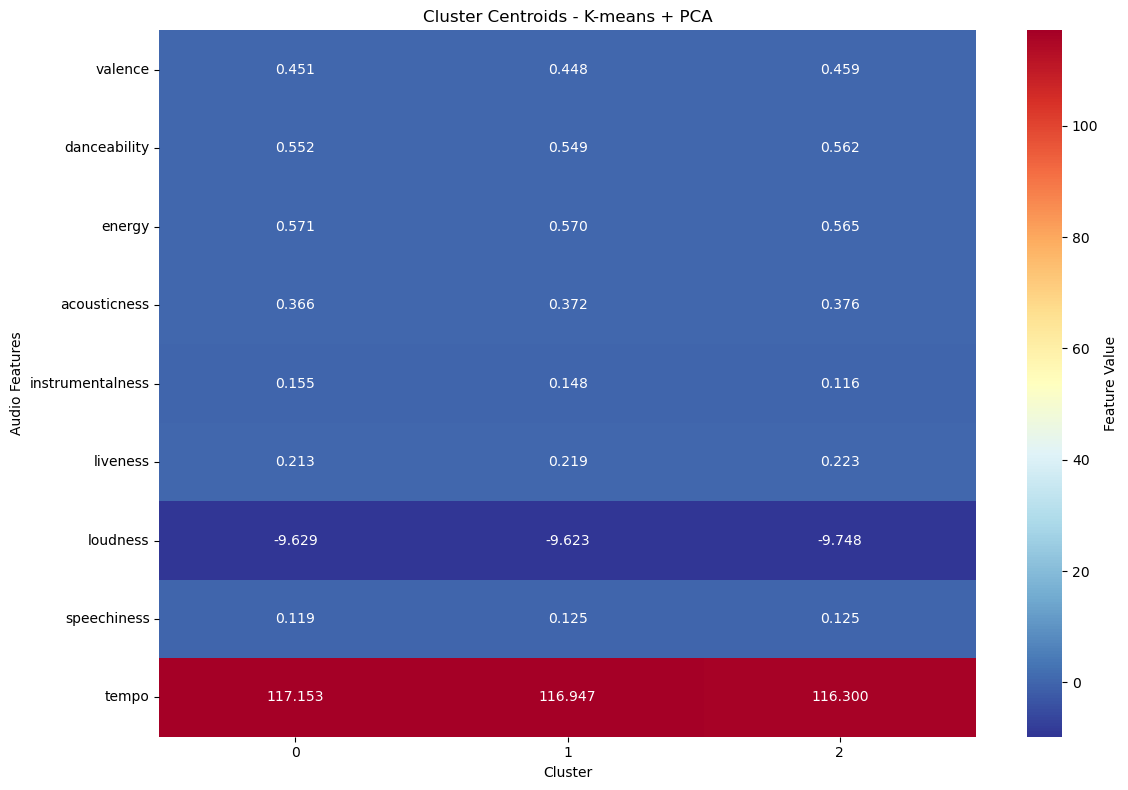

In [39]:
best_labels = kmeans_pca_labels
best_method = "K-means + PCA"

sample_df = df.sample(n=10000, random_state=42).reset_index(drop=True)
sample_df['cluster'] = best_labels

clustered_data = sample_df[sample_df['cluster'] != -1].copy()

cluster_means = clustered_data.groupby('cluster')[clustering_features].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, cmap='RdYlBu_r', fmt='.3f', 
            cbar_kws={'label': 'Feature Value'})
plt.title(f'Cluster Centroids - {best_method}')
plt.xlabel('Cluster')
plt.ylabel('Audio Features')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

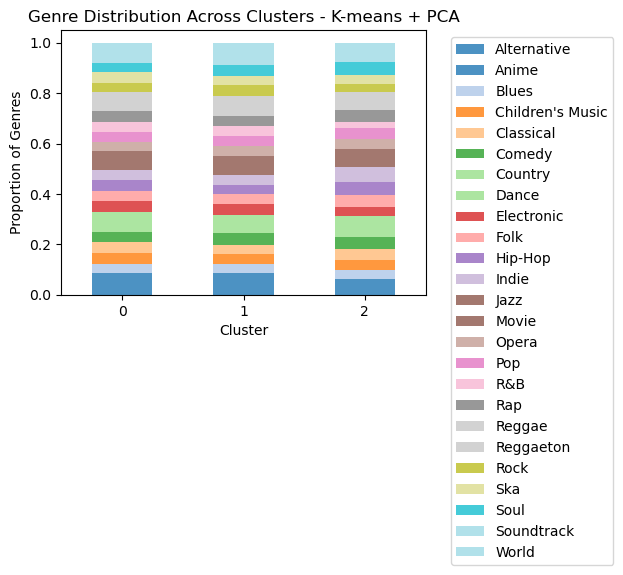

In [40]:
genre_cluster_counts = clustered_data.groupby(['cluster', 'genre']).size().unstack(fill_value=0)
genre_cluster_props = genre_cluster_counts.div(genre_cluster_counts.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
genre_cluster_props.plot(kind='bar', stacked=True, colormap='tab20', alpha=0.8)
plt.title(f'Genre Distribution Across Clusters - {best_method}')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Genres')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_128863/723179525.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


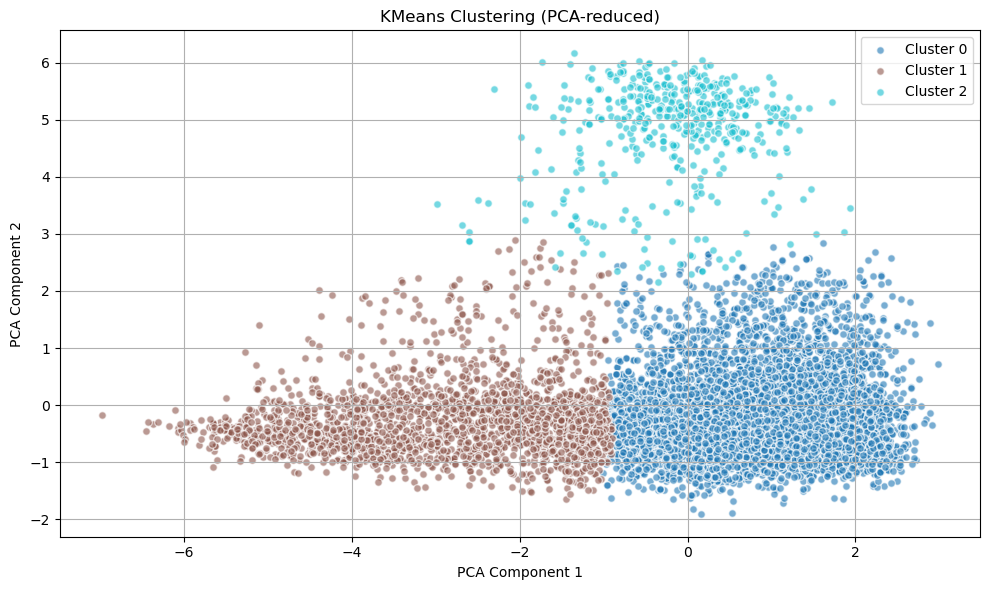

In [41]:
def plot_kmeans_clusters(X_pca, labels, title="KMeans Clustering (PCA-reduced)"):
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    plt.figure(figsize=(10, 6))
    for i, label in enumerate(unique_labels):
        color = colors(i)
        label_name = f"Cluster {label}"

        plt.scatter(
            X_pca[labels == label, 0],
            X_pca[labels == label, 1],
            s=30,
            c=[color],
            label=label_name,
            alpha=0.6,
            edgecolors='w'
        )

    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_kmeans_clusters(X_pca, kmeans_pca_labels)

This may be related to the features we selected for grouping tracks or the distribution of our data, however we can clearly see that 3 clusters don't properly define distinct categories. Even if the regions are well defined, the features don't vary enough. We rerun DBSCAN with finer clustring until we obtain relevant results (with silhouette score optimization): 

In [42]:
"""
def dbscan_objective(trial):
    eps = trial.suggest_float('eps', 0, 5)
    min_samples = trial.suggest_int('min_samples', 10, 200)
    
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    labels = clusterer.fit_predict(X_pca)
        
    n_clusters = len(set(labels))
    if n_clusters < 5:
        return -1
    
    score = silhouette_score(X_pca, labels)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(dbscan_objective, n_trials=1500)

print("Best params:", study.best_params)
print("Best silhouette score:", study.best_value)
"""

'\ndef dbscan_objective(trial):\n    eps = trial.suggest_float(\'eps\', 0, 5)\n    min_samples = trial.suggest_int(\'min_samples\', 10, 200)\n    \n    clusterer = DBSCAN(eps=eps, min_samples=min_samples)\n    labels = clusterer.fit_predict(X_pca)\n        \n    n_clusters = len(set(labels))\n    if n_clusters < 5:\n        return -1\n    \n    score = silhouette_score(X_pca, labels)\n    return score\n\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(dbscan_objective, n_trials=1500)\n\nprint("Best params:", study.best_params)\nprint("Best silhouette score:", study.best_value)\n'

In [43]:
# for 5 clusters: Best params: {'eps': 0.7294703512358712, 'min_samples': 19}
# for 5 clusters: Best params: {'eps': 0.9879183190030392, 'min_samples': 19}

# DBSCAN with dimentionality reduction
start_time = time.time()
dbscan_pca = DBSCAN(eps=0.7294703512358712, min_samples=19)
dbscan_pca_labels = dbscan_pca.fit_predict(X_pca)
dbscan_pca_time = time.time() - start_time

print(f"DBSCAN found {len(np.unique(dbscan_pca_labels))} clusters including {np.sum(dbscan_pca_labels == -1)} noise points")

dbscan_pca_sil, dbscan_pca_ch, dbscan_pca_db = evaluate_clustering(X_sample_scaled, dbscan_pca_labels, "DBSCAN (with PCA)")
print(f"time = {dbscan_pca_time}")

DBSCAN found 5 clusters including 4215 noise points
DBSCAN (with PCA) Evaluation:
  Silhouette Score: 0.0433
  Calinski-Harabasz Index: 609.7497
  Davies-Bouldin Index: 1.9388
  Number of clusters: 5

time = 0.27265286445617676


## Interpretation and visualization

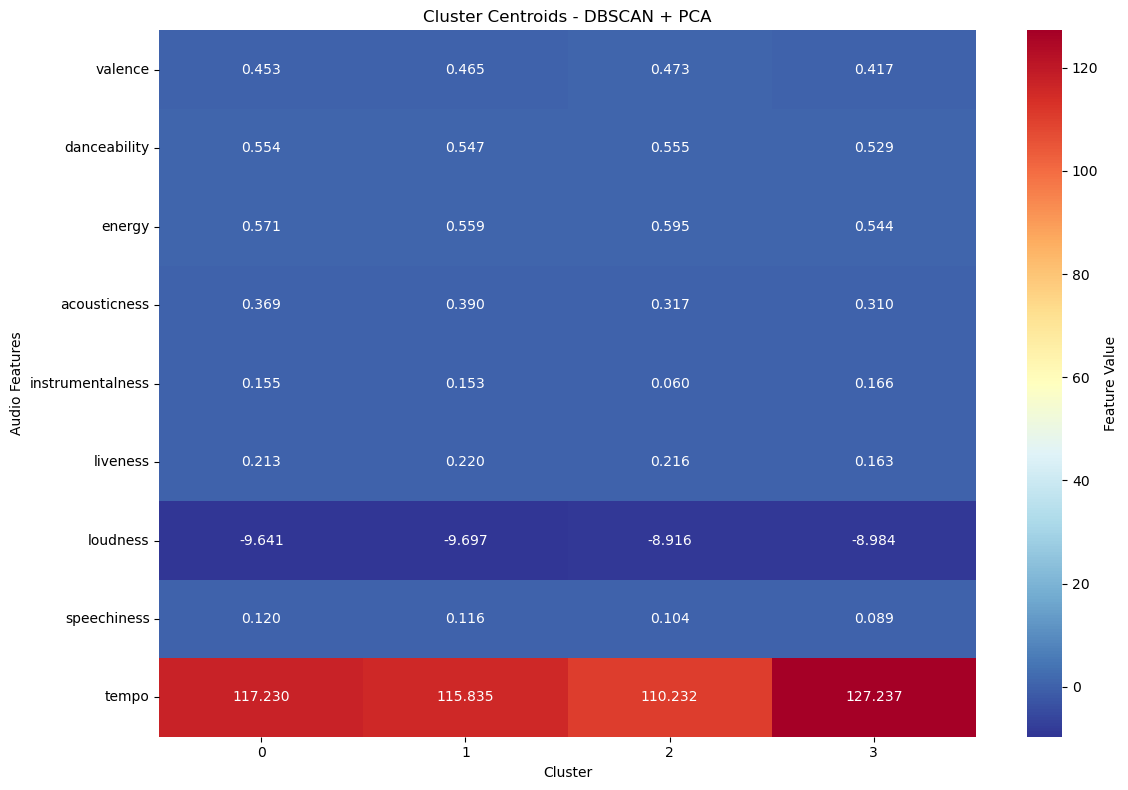

<Figure size 1200x800 with 0 Axes>

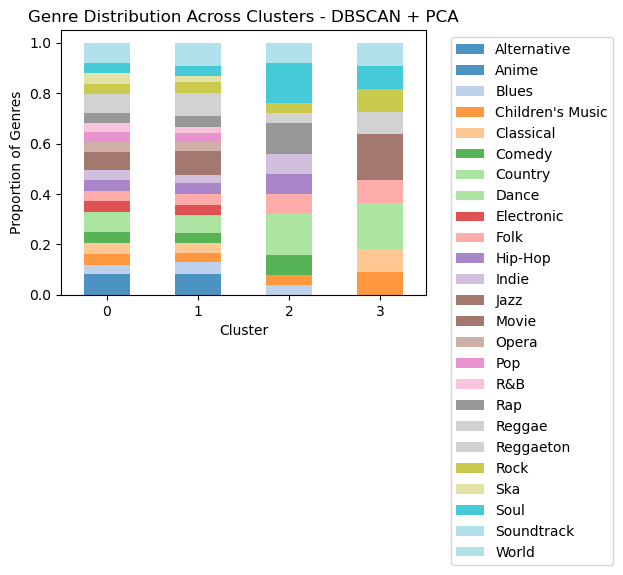

In [44]:
# ## Interpretation and visualization

# Use the best performing method (DBSCAN + PCA) for interpretation
best_labels = dbscan_pca_labels
best_method = "DBSCAN + PCA"

# Create a sample dataframe with cluster labels for analysis
sample_df = df.sample(n=10000, random_state=42).reset_index(drop=True)
sample_df['cluster'] = best_labels

# Remove noise points for cleaner interpretation
clustered_data = sample_df[sample_df['cluster'] != -1].copy()

# Display centroids across feature space
cluster_means = clustered_data.groupby('cluster')[clustering_features].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, cmap='RdYlBu_r', fmt='.3f', 
            cbar_kws={'label': 'Feature Value'})
plt.title(f'Cluster Centroids - {best_method}')
plt.xlabel('Cluster')
plt.ylabel('Audio Features')
plt.tight_layout()
plt.show()

# Display bar plots of genres across clusters
genre_cluster_counts = clustered_data.groupby(['cluster', 'genre']).size().unstack(fill_value=0)
genre_cluster_props = genre_cluster_counts.div(genre_cluster_counts.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
genre_cluster_props.plot(kind='bar', stacked=True, colormap='tab20', alpha=0.8)
plt.title(f'Genre Distribution Across Clusters - {best_method}')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Genres')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_128863/715159708.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


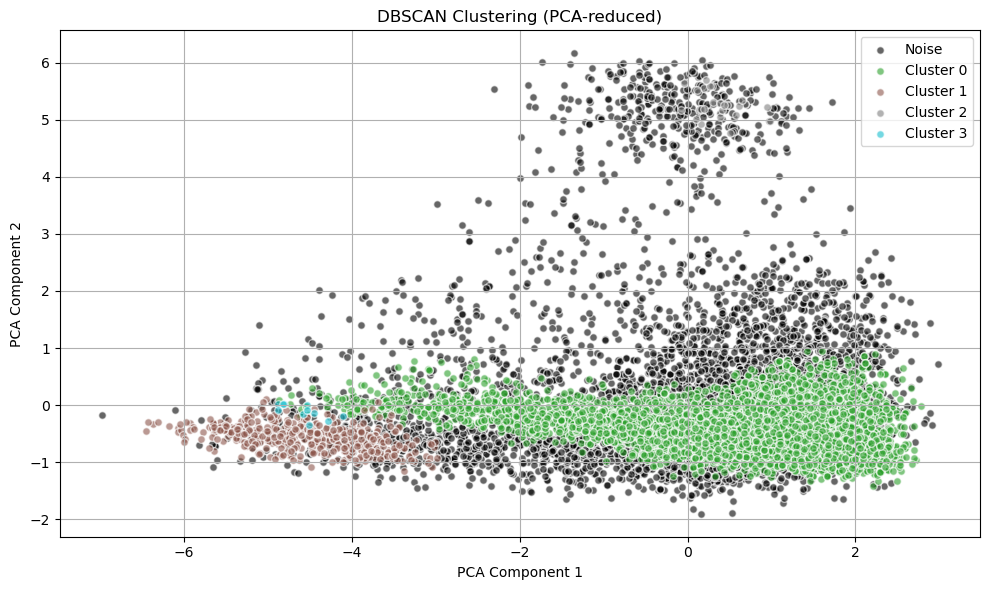

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assume X_pca is the 2D PCA-reduced data and dbscan_pca_labels are the labels from DBSCAN
def plot_dbscan_clusters(X_pca, labels, title="DBSCAN Clustering (PCA-reduced)"):
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    plt.figure(figsize=(10, 6))
    for i, label in enumerate(unique_labels):
        if label == -1:
            # Noise
            color = 'k'
            label_name = "Noise"
        else:
            color = colors(i)
            label_name = f"Cluster {label}"

        plt.scatter(
            X_pca[labels == label, 0],
            X_pca[labels == label, 1],
            s=30,
            c=[color],
            label=label_name,
            alpha=0.6,
            edgecolors='w'
        )

    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_dbscan_clusters(X_pca, dbscan_pca_labels)


**Conclusion:** The only distinctive feature that can be identified in some genres seems to be the difference in tempo, since we are looking at the mean features of a cluster we can assume that the variance is what changes within the clusters that we seek. We make one last attempt by forcing a high number of clusters on the k-mean algorithm.

In [46]:
# K means with dimensionality reduction
start_time = time.time()
kmeans_pca = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans_pca_labels = kmeans_pca.fit_predict(X_pca)
kmeans_pca_time = time.time() - start_time

kmeans_pca_sil, kmeans_pca_ch, kmeans_pca_db = evaluate_clustering(X_sample_scaled, kmeans_pca_labels, "K-means with PCA")
print(f"time = {kmeans_pca_time}")

K-means with PCA Evaluation:
  Silhouette Score: 0.1945
  Calinski-Harabasz Index: 2463.6362
  Davies-Bouldin Index: 1.4518
  Number of clusters: 7

time = 0.07193946838378906


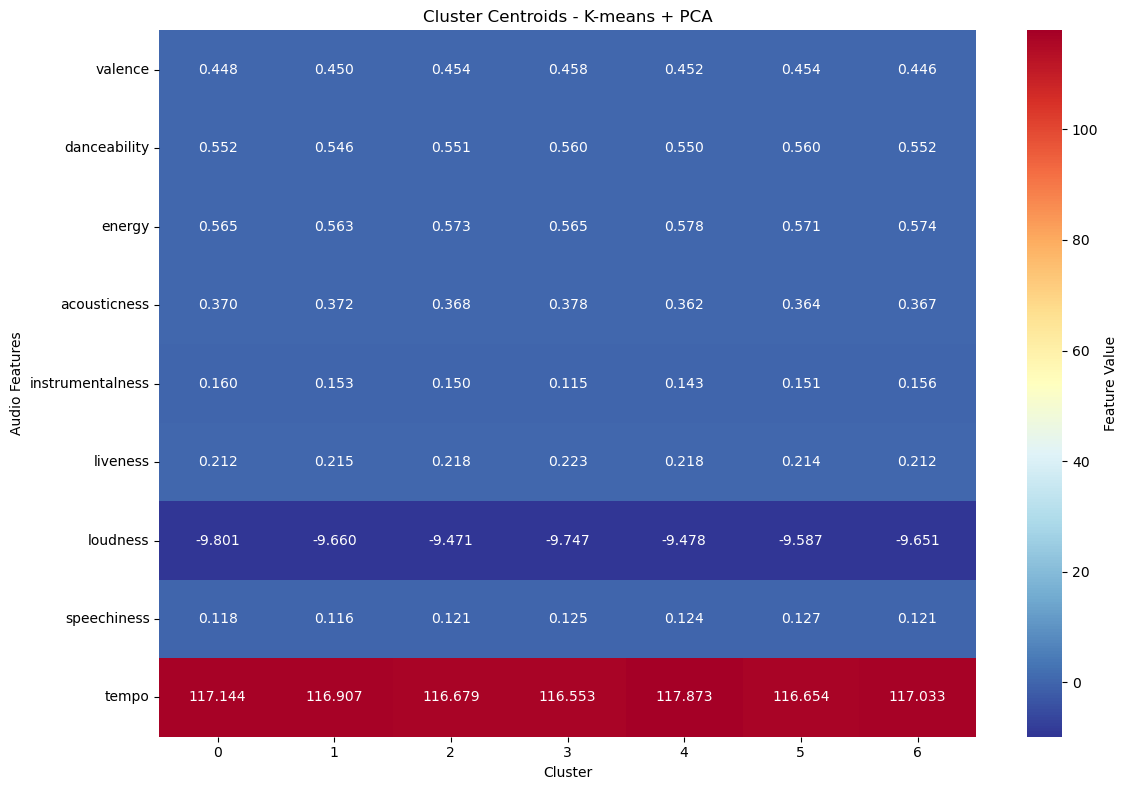

In [47]:
best_labels = kmeans_pca_labels
best_method = "K-means + PCA"

sample_df = df.sample(n=10000, random_state=42).reset_index(drop=True)
sample_df['cluster'] = best_labels

clustered_data = sample_df[sample_df['cluster'] != -1].copy()

cluster_means = clustered_data.groupby('cluster')[clustering_features].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, cmap='RdYlBu_r', fmt='.3f', 
            cbar_kws={'label': 'Feature Value'})
plt.title(f'Cluster Centroids - {best_method}')
plt.xlabel('Cluster')
plt.ylabel('Audio Features')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

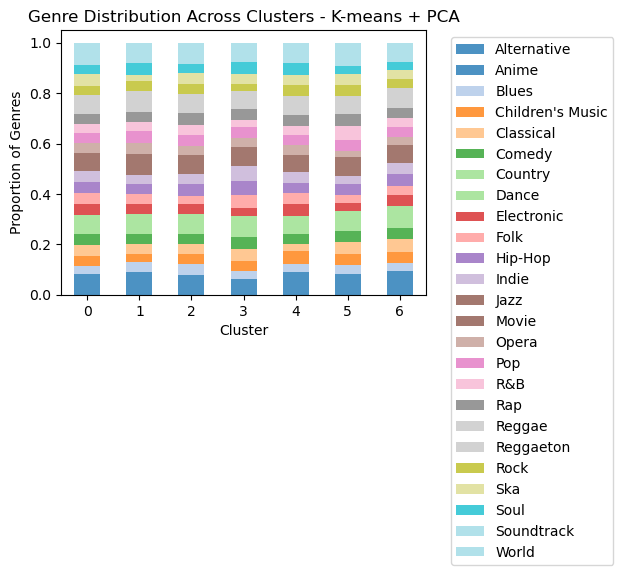

In [48]:
genre_cluster_counts = clustered_data.groupby(['cluster', 'genre']).size().unstack(fill_value=0)
genre_cluster_props = genre_cluster_counts.div(genre_cluster_counts.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
genre_cluster_props.plot(kind='bar', stacked=True, colormap='tab20', alpha=0.8)
plt.title(f'Genre Distribution Across Clusters - {best_method}')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Genres')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_128863/723179525.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


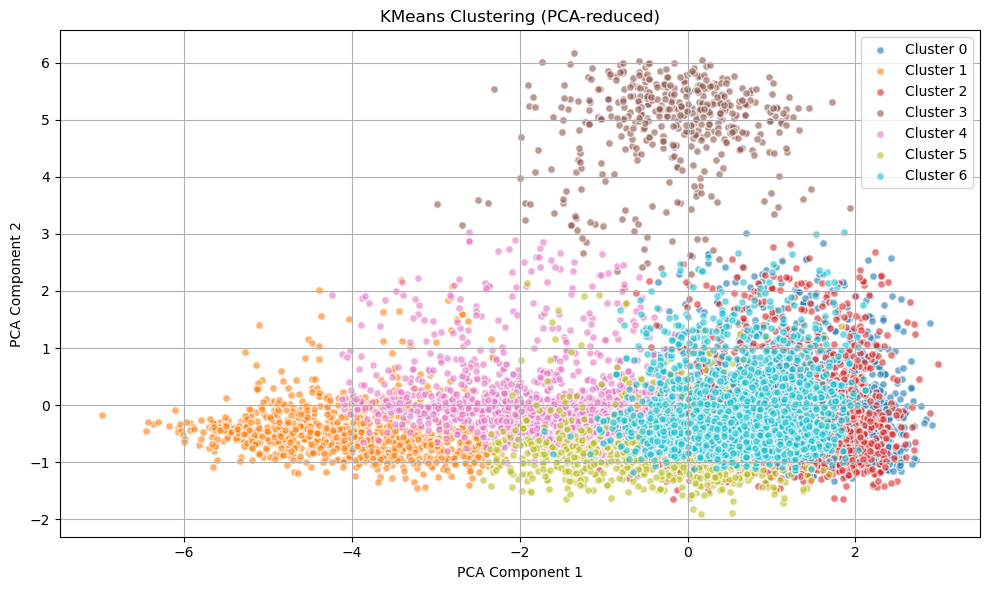

In [49]:
plot_kmeans_clusters(X_pca, kmeans_pca_labels)

We confirm that the mean of the features given by the spotify API per cluster is not enough to identify the groups and return to our optimal k, this time we inspect each cluster closely.

In [50]:
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_pca_labels = kmeans_pca.fit_predict(X_pca)
cluster_df = pd.DataFrame(X_sample_scaled, columns=clustering_features)
cluster_df['cluster'] = kmeans_pca_labels

In [55]:
def describe_cluster(pca_df, cluster_id):
    cluster_data = pca_df[pca_df['cluster'] == cluster_id]

    print(f"\n📊 Statistics for Cluster {cluster_id} ({len(cluster_data)} points):\n")
    display(cluster_data.describe())

    cluster_data.drop(columns='cluster').hist(bins=50, figsize=(10, 4), layout=(1, len(cluster_data.columns) - 1))
    plt.suptitle(f"Distribution of PCA components for Cluster {cluster_id}", fontsize=14)
    plt.tight_layout()
    plt.show()


📊 Statistics for Cluster 0 (7190 points):



,valence,danceability,energy,acousticness,instrumentalness,liveness,loudness,speechiness,tempo,cluster
count,7190.000000,7190.000000,7190.000000,7190.000000,7190.000000,7190.000000,7190.000000,7190.000000,7190.000000,7190.0
mean,0.310605,0.321870,0.412335,-0.486056,-0.270062,-0.084611,0.445967,-0.132617,0.148231,0.0
std,0.909244,0.826065,0.685791,0.641988,0.647881,0.831818,0.464664,0.513421,0.964814,0.0
min,-1.630459,-2.401402,-1.762678,-1.042036,-0.494135,-0.981038,-1.800952,-0.526499,-2.373764,0.0
25%,-0.399481,-0.249414,-0.097590,-0.992966,-0.494135,-0.608003,0.177373,-0.450803,-0.655701,0.0
50%,0.319198,0.373107,0.434629,-0.757586,-0.494104,-0.418274,0.516500,-0.356442,0.092076,0.0
75%,1.026347,0.936595,0.974452,-0.163327,-0.485582,0.228979,0.778045,-0.053659,0.803166,0.0
max,2.067855,2.278234,1.628322,1.754634,2.729863,3.850630,1.916460,3.591145,3.393482,0.0


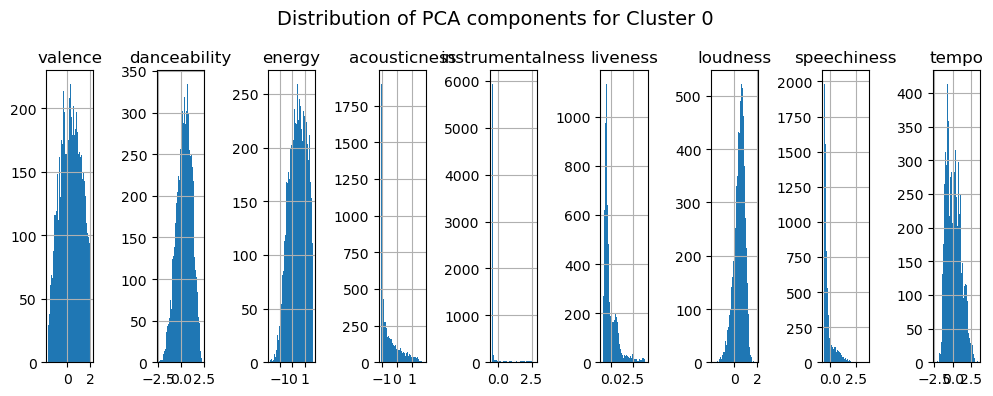


📊 Statistics for Cluster 1 (2336 points):



,valence,danceability,energy,acousticness,instrumentalness,liveness,loudness,speechiness,tempo,cluster
count,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.0
mean,-0.904159,-0.998479,-1.347379,1.262518,0.930741,-0.255045,-1.289789,-0.388670,-0.334351,1.0
std,0.698739,0.902922,0.564075,0.622890,1.359948,0.731849,1.076085,0.207273,1.000971,0.0
min,-1.663510,-2.658997,-2.168522,-1.042036,-0.494135,-0.950405,-5.569308,-0.517685,-2.415334,1.0
25%,-1.473368,-1.753391,-1.811053,1.098415,-0.492882,-0.606027,-1.929019,-0.464283,-1.160597,1.0
50%,-1.123925,-1.040980,-1.412933,1.519466,0.795464,-0.522032,-1.064762,-0.434730,-0.528682,1.0
75%,-0.514777,-0.323204,-0.994761,1.684225,2.407463,-0.289812,-0.460301,-0.392735,0.380882,1.0
max,1.998677,1.924041,0.932635,1.763083,2.769341,3.816044,1.016450,2.445339,3.109900,1.0


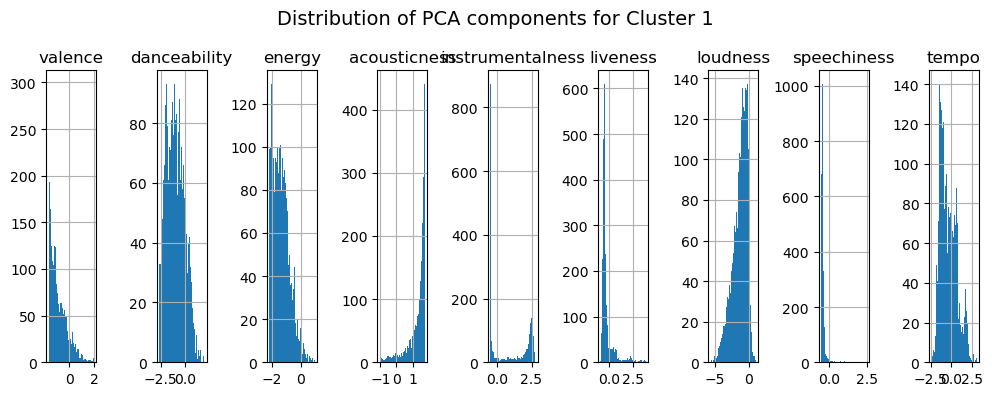


📊 Statistics for Cluster 2 (474 points):



,valence,danceability,energy,acousticness,instrumentalness,liveness,loudness,speechiness,tempo,cluster
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.0
mean,-0.255563,0.038399,0.385635,1.150839,-0.490429,2.540372,-0.408347,3.927108,-0.600707,2.0
std,0.772599,0.495688,0.850582,0.414367,0.063489,1.041190,0.858820,0.674518,0.894302,0.0
min,-1.603556,-2.149174,-1.931467,-1.010498,-0.494135,-0.795756,-3.776446,0.272974,-2.359853,2.0
25%,-0.895254,-0.289663,-0.195481,1.017444,-0.494135,2.231263,-0.886749,4.016286,-1.206775,2.0
50%,-0.247675,0.064530,0.527768,1.235010,-0.494135,2.731525,-0.285618,4.177010,-0.925452,2.0
75%,0.265393,0.377132,1.128416,1.396249,-0.494135,3.335545,0.222739,4.254780,-0.043328,2.0
max,1.979461,1.795244,1.624520,1.754634,0.854680,3.801221,1.540207,4.358473,2.274498,2.0


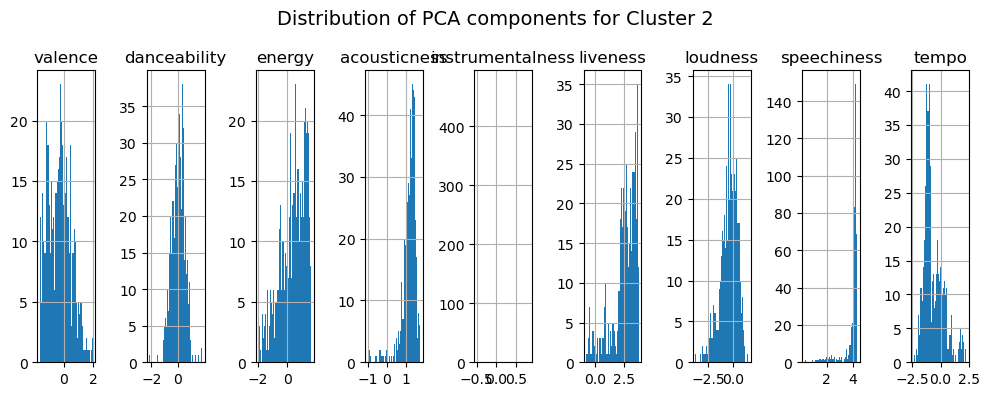

In [56]:
for i in range(optimal_k):
    describe_cluster(cluster_df, i)

We label our final clusters according to relatively consistent features with low variance within a cluster: 
- light music (cluster 0): high valence, high loudness, varying tempo, almost always minimal speechiness. Music appropriate for a casual listen or as a background of a light scene or casual media.
- heavy music (cluster 1): varying valence, limited tempo, less speechiness than light music. Music with a message and more emotion.
- not music (cluster 2): podcasts and such. 